In [1]:
# =======================
# This notebook calculates the correlation between the OFFLINE DPCO2 Multiple Linear Regression (MLR)
# and the online calculation of DPCO2. It allows us to then HOLD ONE VARIABLE CONSTANT and estimate
# the effect/importance of that variable
# =======================

# A batch script that does this for each model also exists here:
# SUBMIT_dpco2_MLR_PlotMaps_ByModel.sh
# dpco2_MLR_PlotMaps_ByModel.py

In [2]:
import netCDF4
import os
import numpy as np
import pickle
import sys
from scipy import stats
from scipy import interpolate
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib
%matplotlib inline

model = "IPSLCM6A"
# model = "EC-Earth3-CC"
# model = "CESM2"
# model = "CESM2-FV2"
# model = "CESM2-WACCM"
# model = "CESM2-WACCM-FV2"
# model = "UKESM1-0-LL"
# model = "NorESM2-LM"
# model = "CMCC-ESM2"
# model = "CNRM-ESM2-1"
# model = "GISS-E2-1-G"
# model = "GISS-E2-1-G-CC"

remake_combined_save = True
remake_figures = True

corr_titles = ['full', '(tos clim)', '(mlotst clim)', '(intpp clim)']
corrDiff_titles = ['full', '(tos impact)', '(mlotst impact)', '(intpp impact)']
ncorrs = len(corr_titles)

season_titles = ['Annual', 'MAM', 'JJA', 'SON', 'DJF', 'SeasonalCycle']
coef_titles = ['tos scaling', 'mlotst scaling', 'intpp scaling', 'intercept']

cmap = plt.get_cmap('coolwarm')

smoothing = 5
detrending = 100

## This results in using seasonal data that is anomalies relative to that year.
deannualise = False

output_dir = '/home/mmenary/python/notebooks/CO2_Py3x/output'
datadir = '/data/mmenary/python_saves'
var_names = ['dpco2', 'tos', 'mlotst', 'intpp']

block_len = 30

nseasons = 6  # 4 + 1 annual + 1 Seasonal Cycle
ncoefs = 4  ## 3 scalings and 1 intercept
npreds = 4  ## 1 full prediction and 3 with different variables held constant

In [3]:
def get_ji_for_block(block_number, block_len):
    nblocks_j = np.int(np.ceil(nj / np.float(block_len)))
    nblocks_i = np.int(np.ceil(ni / np.float(block_len)))

    block_j = np.int(block_number // nblocks_i)
    block_i = np.int(block_number - (block_j * nblocks_i))

    j0 = block_j * block_len
    i0 = block_i * block_len
    j1 = np.min((((block_j + 1) * block_len), nj))
    i1 = np.min((((block_i + 1) * block_len), ni))

    return [j0, j1, i0, i1]

nj_re = 180
ni_re = 360
lon_re = np.repeat((np.arange(-180, 180) + 0.5)[np.newaxis, :], nj_re, axis=0)
lat_re = np.repeat((np.arange(-90, 90) + 0.5)[:, None], ni_re, axis=1)

def regrid(arr2d, lon, lat):
    print("Regridding")
    arr2d_re = interpolate.griddata(np.array([lat.ravel(), lon.ravel()]).T,
                                    arr2d.ravel(), (lat_re, lon_re),
                                    method='linear')
    mask_re = interpolate.griddata(np.array([lat.ravel(), lon.ravel()]).T,
                                   arr2d.mask.ravel(), (lat_re, lon_re),
                                   method='linear')
    arr2d_re = np.ma.array(arr2d_re, mask=mask_re)
    return arr2d_re

smoothing_string = ''
if smoothing > 1:
    smoothing_string = '_Smo{:d}'.format(smoothing)

detrending_string = ''
if detrending > 1:
    detrending_string = '_det{:d}'.format(detrending)

deannualised_string = ''
if deannualise:
    deannualised_string = '_AnnAnoms'

fig_save_file1 = '{:s}/dpco2_MLR_coefficients_{:s}{:s}{:s}{:s}.png'.format(output_dir, model, deannualised_string, smoothing_string, detrending_string)
fig_save_file2 = '{:s}/dpco2_MLR_correlations_{:s}{:s}{:s}{:s}.png'.format(output_dir, model, deannualised_string, smoothing_string, detrending_string)
fig_save_file3 = '{:s}/dpco2_MLR_correlations_Zoom_{:s}{:s}{:s}{:s}.png'.format(output_dir, model, deannualised_string, smoothing_string, detrending_string)
fig_save_file4 = '{:s}/dpco2_MLR_correlationDiffs_{:s}{:s}{:s}{:s}.png'.format(output_dir, model, deannualised_string, smoothing_string, detrending_string)
fig_save_file5 = '{:s}/dpco2_MLR_correlationDiffs_Zoom_{:s}{:s}{:s}{:s}.png'.format(output_dir, model, deannualised_string, smoothing_string, detrending_string)

if (not remake_figures) and (not remake_combined_save):
    if os.path.isfile(fig_save_file1) and os.path.isfile(fig_save_file2) and os.path.isfile(fig_save_file3) and os.path.isfile(fig_save_file4) and os.path.isfile(fig_save_file5):
        raise ValueError("Don't need to run")

tempdir = '/data/mmenary/fgco2_blocks/{:s}'.format(model)

# example_file = '/data/mmenary/fgco2/{:s}/dpco2_temp.nc'.format(model)
example_file = '/thredds/ipsl/mmenary/fgco2/{:s}/dpco2_temp.nc'.format(model)
loaded = netCDF4.Dataset(example_file)

if model == "IPSLCM6A":
    nj = 332
    ni = 362
    lon = loaded.variables['nav_lon'][:]
    lat = loaded.variables['nav_lat'][:]
elif model == "UKESM1-0-LL":
    nj = 330
    ni = 360
    lon = loaded.variables['longitude'][:]
    lat = loaded.variables['latitude'][:]
elif model == "EC-Earth3-CC":
    nj = 292
    ni = 362
    lon = loaded.variables['longitude'][:]
    lat = loaded.variables['latitude'][:]
    lon[lon > 180] -= 360
elif (model == "CESM2") or (model == "CESM2-FV2") or (model == "CESM2-WACCM") or (model == "CESM2-WACCM-FV2"):
    if (model == "CESM2-FV2") or (model == "CESM2-WACCM-FV2"):
        ## Don't have data for these models
        raise ValueError("No data for these models")
    nj = 384
    ni = 320
    lon = loaded.variables['lon'][:]
    lat = loaded.variables['lat'][:]
    lon[lon > 180] -= 360
elif model == "NorESM2-LM":
    nj = 385
    ni = 360
    lon = loaded.variables['longitude'][:]
    lat = loaded.variables['latitude'][:]
    lon[lon > 180] -= 360
elif model == "CNRM-ESM2-1":
    nj = 294
    ni = 362
    lon = loaded.variables['lon'][:]
    lat = loaded.variables['lat'][:]
elif model == "CMCC-ESM2":
    nj = 292
    ni = 362
    lon = loaded.variables['longitude'][:]
    lat = loaded.variables['latitude'][:]
    lon[lon > 180] -= 360
elif (model == "GISS-E2-1-G") or (model == "GISS-E2-1-G-CC"):
    nj = 180
    ni = 288
    lon = loaded.variables['lon'][:]
    lat = loaded.variables['lat'][:]
    lon[lon > 180] -= 360

In [4]:
combined_file = 'dpco2_MLR_{:s}{:s}{:s}{:s}.pkl'.format(model, deannualised_string, smoothing_string, detrending_string)
combined_save_file = os.path.join(datadir, combined_file)
if os.path.isfile(combined_save_file) and not remake_combined_save:
    print("Reading from {:s}".format(combined_save_file))
    with open(combined_save_file, 'rb') as handle:
        coefficients_map_data, coefficients_map_mask, correlations_map_data, correlations_map_mask = pickle.load(handle)
        coefficients_map = np.ma.array(coefficients_map_data, mask=coefficients_map_mask)
        correlations_map = np.ma.array(correlations_map_data, mask=correlations_map_mask)
else:
    coefficients_map = np.ma.masked_all(shape=(nseasons, nj, ni, ncoefs))
    correlations_map = np.ma.masked_all(shape=(nseasons, nj, ni, npreds))

    total_blocks = np.int(np.ceil(nj / np.float(block_len)) * np.ceil(ni / np.float(block_len)))
    for block_number in range(total_blocks):
        block_number_filled = '{:d}'.format(block_number).zfill(6)
        input_file = 'dpco2_MLR_Block{:s}-{:d}{:s}{:s}{:s}.pkl'.format(block_number_filled, block_len, deannualised_string, smoothing_string, detrending_string)
        in_save_file = os.path.join(tempdir, input_file)

        if not os.path.isfile(in_save_file):
            print("--- Skipping: {:s}".format(in_save_file))
            continue

        print("Reading from: {:s}".format(in_save_file))
        with open(in_save_file, 'rb') as handle:
            coefficients_map_data, coefficients_map_mask, correlations_map_data, correlations_map_mask = pickle.load(handle)

        j0, j1, i0, i1 = get_ji_for_block(block_number, block_len)

        coefficients_map[:, j0:j1, i0:i1, :] = coefficients_map_data[:, j0:j1, i0:i1, :]
        coefficients_map[:, j0:j1, i0:i1, :].mask = coefficients_map_mask[:, j0:j1, i0:i1, :]
        correlations_map[:, j0:j1, i0:i1, :] = correlations_map_data[:, j0:j1, i0:i1, :]
        correlations_map[:, j0:j1, i0:i1, :].mask = correlations_map_mask[:, j0:j1, i0:i1, :]

    print("Writing to: {:s}".format(combined_save_file))
    with open(combined_save_file, 'wb') as handle:
        pickle.dump([coefficients_map.data, coefficients_map.mask, correlations_map.data, correlations_map.mask],
                    handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Done!")

if (not remake_figures):
    if os.path.isfile(fig_save_file1) and os.path.isfile(fig_save_file2) and os.path.isfile(fig_save_file3) and os.path.isfile(fig_save_file4) and os.path.isfile(fig_save_file5):
        raise ValueError("Don't need to run")

--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000000-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000001-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000002-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000003-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000004-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000005-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000006-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000007-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000008-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000009-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000010-30_Smo5_det100.pkl

Reading from: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000098-30_Smo5_det100.pkl
Reading from: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000099-30_Smo5_det100.pkl
Reading from: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000100-30_Smo5_det100.pkl
Reading from: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000101-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000102-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000103-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000104-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000105-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000106-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000107-30_Smo5_det100.pkl
--- Skipping: /data/mmenary/fgco2_blocks/IPSLCM6A/dpco2_MLR_Block000108-30_Smo5_det100.pkl

In [5]:
# tos

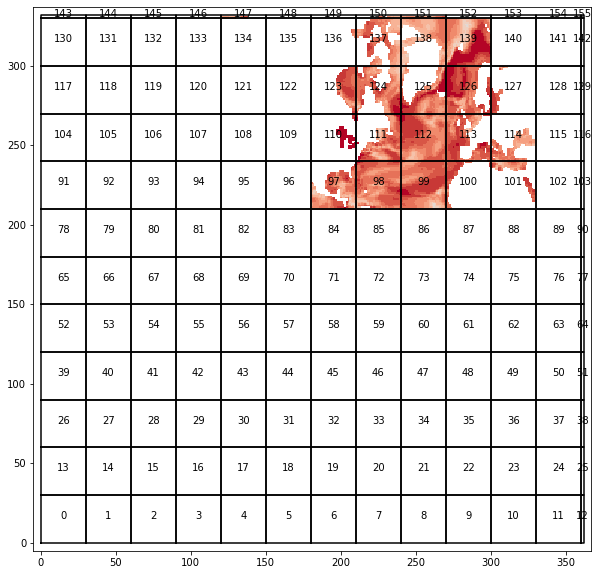

In [6]:
# =======================
# Show the various block numbers/locations
# =======================

nblocks = np.int(np.ceil(362 / block_len) * np.ceil(332 / block_len))
xlim = (-5, ni + 5)
ylim = (-5, nj + 5)

levels = np.linspace(-1, 1, 21)
cmap = plt.get_cmap('coolwarm')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.figure(figsize=(10, 10))
plt.pcolormesh(correlations_map[0, :, :, 0], cmap=cmap, norm=norm)
plt.xlim(xlim)
plt.ylim(ylim)
for block_number in range(0, nblocks):
    j0, j1, i0, i1 = get_ji_for_block(block_number, block_len)
    plt.plot([i0, i1, i1, i0, i0], [j0, j0, j1, j1, j0], color = 'k')
    plt.text((i0 + i1) / 2., (j0 + j1) / 2., '{:d}'.format(block_number), ha='center')

/home/mmenary/python/notebooks/CO2_Py3x/output/dpco2_MLR_coefficients_IPSLCM6A_Smo5_det100.png


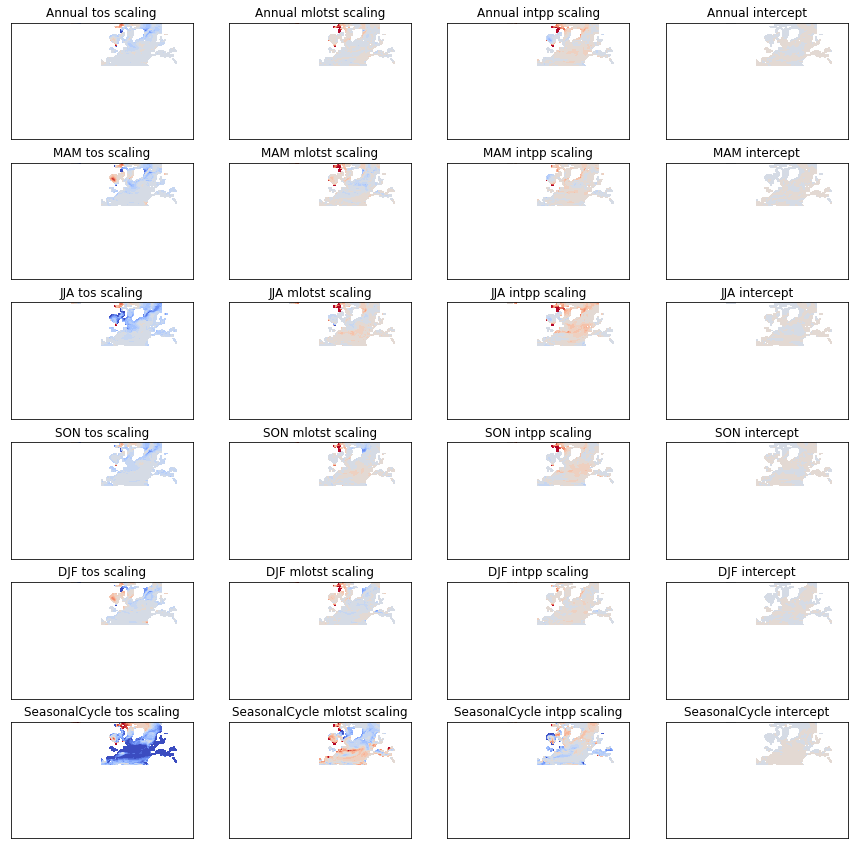

In [7]:
# =======================
# The various scaling coefficients
# =======================

levels = np.linspace(-2, 2, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('white')
for season in range(nseasons):
    for icoef in range(ncoefs):
        if icoef == 4: continue
        plt.subplot(nseasons, ncoefs, season * ncoefs + icoef + 1)
        plt.pcolormesh(coefficients_map[season, :, :, icoef], cmap=cmap, norm=norm)
        plt.title('{:s} {:s}'.format(season_titles[season], coef_titles[icoef]))
        plt.xticks([])
        plt.yticks([])

plt.savefig(fig_save_file1, bbox_inches = 'tight')
print(fig_save_file1)

/home/mmenary/python/notebooks/CO2_Py3x/output/dpco2_MLR_correlations_IPSLCM6A_Smo5_det100.png


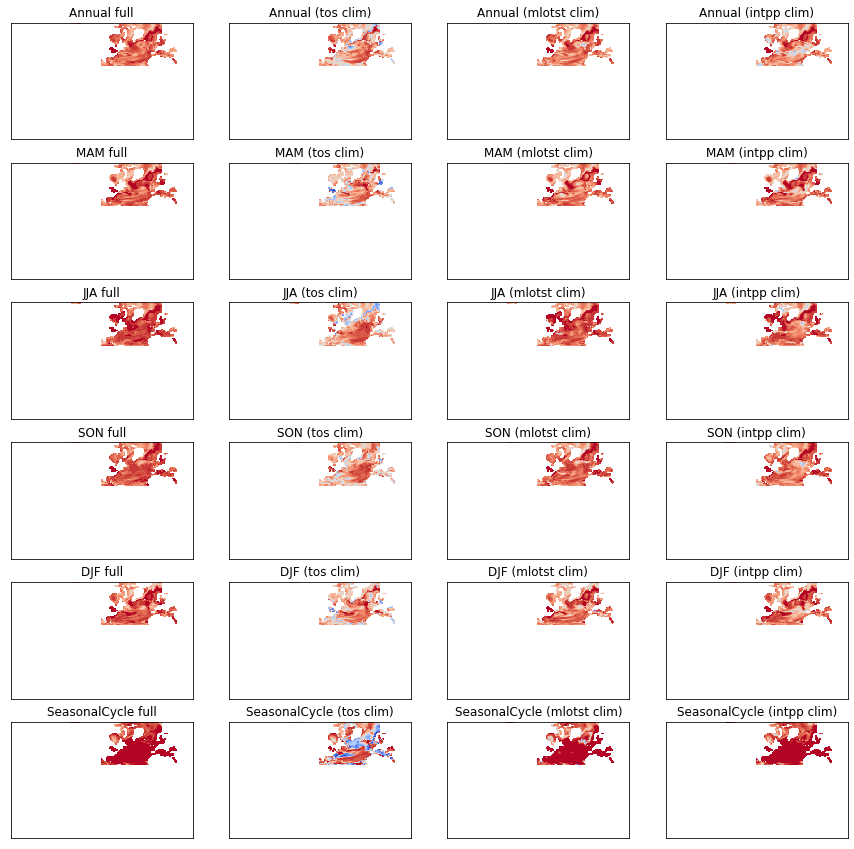

In [8]:
# =======================
# The corr.s between the dpco2 and the dpco2 from the full MLR and MLRs using clim.
# =======================

levels = np.linspace(-1, 1, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('white')
for season in range(nseasons):
    for icorr in range(ncorrs):
        plt.subplot(nseasons, ncorrs, season * ncorrs + icorr + 1)
        plt.pcolormesh(correlations_map[season, :, :, icorr], cmap=cmap, norm=norm)
        plt.title('{:s} {:s}'.format(season_titles[season], corr_titles[icorr]))
        plt.xticks([])
        plt.yticks([])

plt.savefig(fig_save_file2, bbox_inches = 'tight')
print(fig_save_file2)

Regridding


/home/mmenary/anaconda2/envs/py3x/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
/home/mmenary/python/notebooks/CO2_Py3x/output/dpco2_MLR_correlations_Zoom_IPSLCM6A_Smo5_det100.png


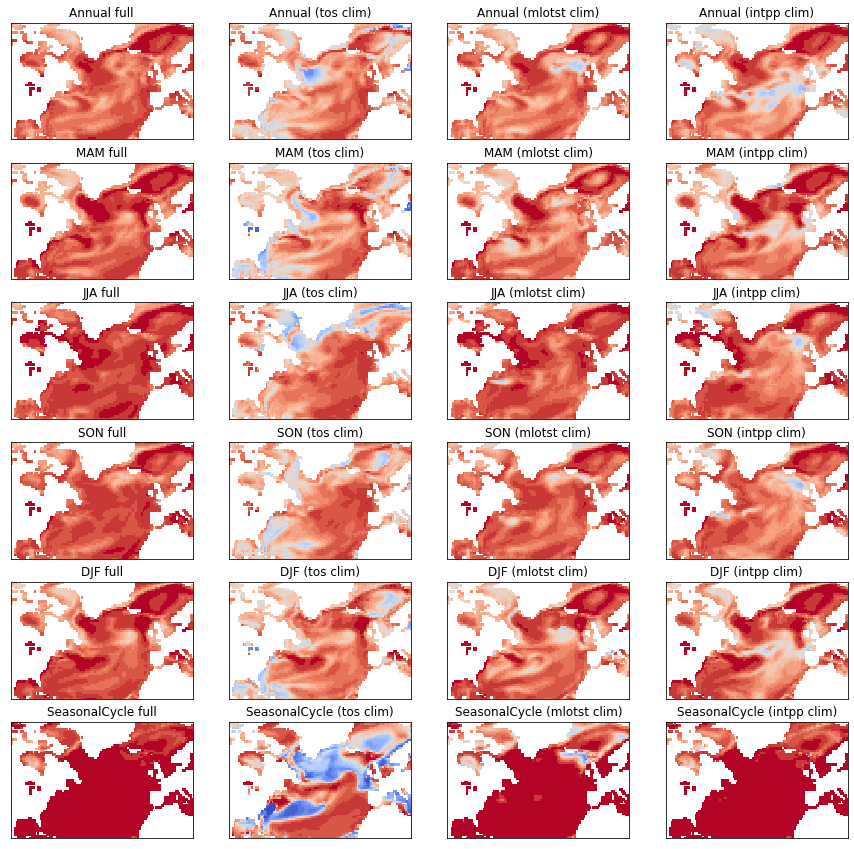

In [9]:
# =======================
# As above but just the North Atlantic
# =======================

levels = np.linspace(-1, 1, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

xlim = [-100, 20]
ylim = [20, 80]

fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('white')
for season in range(nseasons):
    for icorr in range(ncorrs):
        plt.subplot(nseasons, ncorrs, season * ncorrs + icorr + 1)
        this_map = correlations_map[season, :, :, icorr]
        this_map_regridded = regrid(this_map, lon, lat)
        plt.pcolormesh(lon_re, lat_re, this_map_regridded, cmap=cmap, norm=norm)
        plt.title('{:s} {:s}'.format(season_titles[season], corr_titles[icorr]))
        plt.xticks([])
        plt.yticks([])
        plt.xlim(xlim)
        plt.ylim(ylim)

plt.savefig(fig_save_file3, bbox_inches = 'tight')
print(fig_save_file3)

/home/mmenary/python/notebooks/CO2_Py3x/output/dpco2_MLR_correlationDiffs_IPSLCM6A_Smo5_det100.png


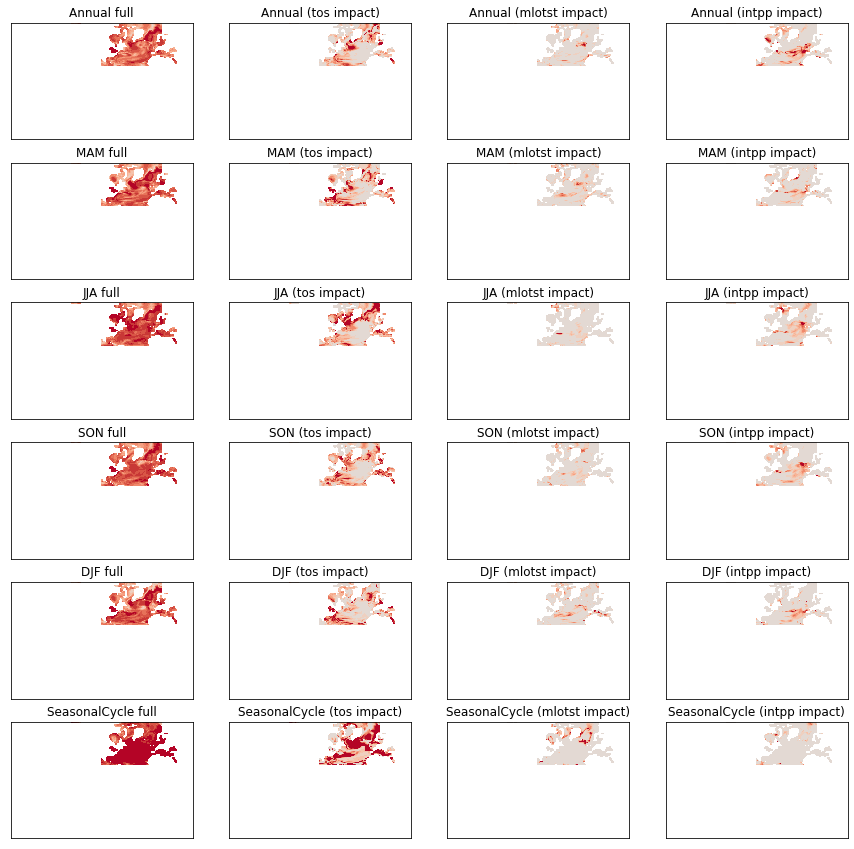

In [10]:
# =======================
# The difference in corr. wrt the full (so red means important)
# TODO in FUTURE: Do correlation differences using Fisher transform
# =======================

levels = np.linspace(-1, 1, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('white')
for season in range(nseasons):
    for icorr in range(ncorrs):
        plt.subplot(nseasons, ncorrs, season * ncorrs + icorr + 1)
        if icorr == 0:
            this_corr_diff = correlations_map[season, :, :, 0]
            title = '{:s} {:s}'.format(season_titles[season], '(dpco2 MLR v dpco2 online)')
        else:
            this_corr_diff = correlations_map[season, :, :, 0] - correlations_map[season, :, :, icorr]
            title = '{:s} {:s}'.format(season_titles[season], corrDiff_titles[icorr])
        plt.pcolormesh(this_corr_diff, cmap=cmap, norm=norm)
        plt.title('{:s} {:s}'.format(season_titles[season], corrDiff_titles[icorr]))
        plt.xticks([])
        plt.yticks([])

plt.savefig(fig_save_file4, bbox_inches = 'tight')
print(fig_save_file4)

Regridding


/home/mmenary/anaconda2/envs/py3x/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
Regridding
/home/mmenary/python/notebooks/CO2_Py3x/output/dpco2_MLR_correlationDiffs_Zoom_IPSLCM6A_Smo5_det100.png


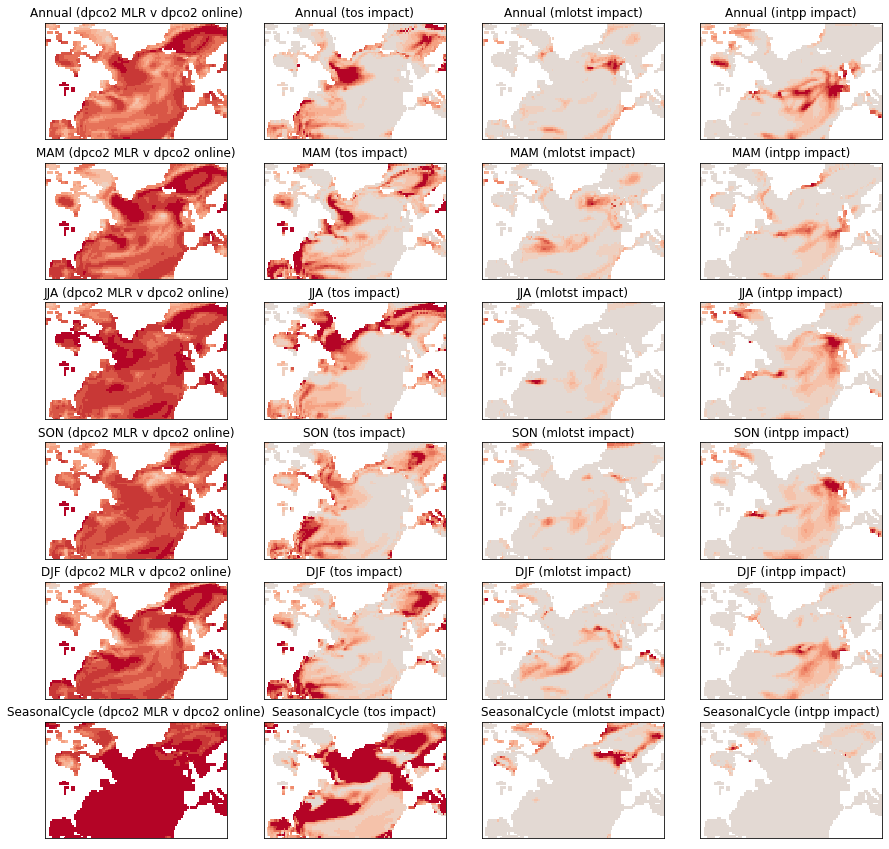

In [11]:
# =======================
# As above but just the North Atlantic
# =======================

levels = np.linspace(-1, 1, 21)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

xlim = [-100, 20]
ylim = [20, 80]

fig = plt.figure(figsize=(15, 15))
fig.patch.set_facecolor('white')
for season in range(nseasons):
    for icorr in range(ncorrs):
        plt.subplot(nseasons, ncorrs, season * ncorrs + icorr + 1)
        if icorr == 0:
            this_corr_diff = correlations_map[season, :, :, 0]
            title = '{:s} {:s}'.format(season_titles[season], '(dpco2 MLR v dpco2 online)')
        else:
            this_corr_diff = correlations_map[season, :, :, 0] - correlations_map[season, :, :, icorr]
            title = '{:s} {:s}'.format(season_titles[season], corrDiff_titles[icorr])
        this_corr_diff_regridded = regrid(this_corr_diff, lon, lat)
        plt.pcolormesh(lon_re, lat_re, this_corr_diff_regridded, cmap=cmap, norm=norm)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        plt.xlim(xlim)
        plt.ylim(ylim)

plt.savefig(fig_save_file5, bbox_inches = 'tight')
print(fig_save_file5)
